# Deploying code

## Deploy to edge devices (smartphones, microcontroller) --> TFLite

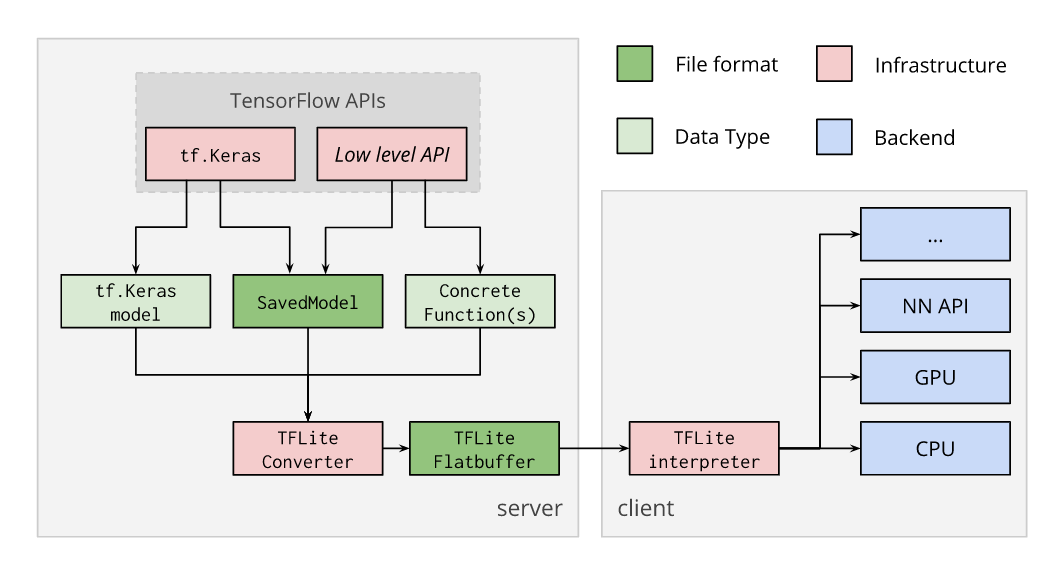

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio as io


# !pip install tensorflow-model-optimization tf-keras
import tensorflow_model_optimization as tfmot
import tempfile
import os
import zipfile

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(10))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])
model.summary()

In [ ]:
# load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
model.fit(x_train, y_train, epochs=20, batch_size=64)

In [ ]:
# save model
model.save("model.h5")

In [ ]:
# load model from h5 file
model = tf.keras.models.load_model("model.h5")

In [ ]:
model.evaluate(x_test, y_test)

### Create TFLite converter

#### Without Quantization

https://www.tensorflow.org/lite/guide/ops_compatibility \
https://www.tensorflow.org/lite/guide/op_select_allowlist

In [ ]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]

# Converter specifications
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

In [ ]:
# save tflite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
# Load TFLite interpreter with our converted model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input tensors
input_details = interpreter.get_input_details()
input_details

In [ ]:
# Get output tensors
output_details = interpreter.get_output_details()
output_details

In [ ]:
input_data = np.array(x_test[0][None, ...], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()

In [ ]:
output_data = interpreter.get_tensor(output_details[0]['index'])
np.argmax(output_data)

In [ ]:
# compare with original TensorFlow model
for test_image, test_label in zip(x_test[0:5], y_test[0:5]):
    # Get prediction of TF model
    result_tf = model.predict(test_image[None, ...], verbose=0)
    
    # Get prediction of TFLite model
    input_data = np.array(test_image[None, ...], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    result_tflite = interpreter.get_tensor(output_details[0]['index'])
    
    print(f"True Label: {int(test_label)}; TF model: {np.argmax(result_tf)}; TFLite model: {np.argmax(result_tflite)}")


In [ ]:
# save 5 of the test files with class label in the file name
random_indices = np.random.choice(range(len(x_test)), 5)
for i in random_indices:
    io.imwrite(f"test_image_{y_test[i][0]}.png", x_test[i])

#### With Quantization
- **Quantization** is a technique that reduces the precision of model parameters (e.g., from 32-bit floating point to 8-bit integers) to improve efficiency.  
- It **reduces model size, speeds up inference, and lowers power consumption**, making models suitable for edge and mobile deployment.  
- Can be **post-training quantization (PTQ)** (applied after training) or **quantization-aware training (QAT)** (incorporated during training for better accuracy).  
- Common types include **weight quantization**, **activation quantization**, and **integer-only inference**.  
- Often used alongside pruning for **maximum model compression and efficiency**.  
- Essential for **deploying deep learning models on mobile devices, embedded systems, and low-power hardware**.  

https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]

def representative_dataset():
    for i in range(200):
        yield [np.asarray(x_train[i], dtype='float32')[None, ...]]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8


converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quantized = converter.convert()

In [ ]:
with open("model_quantized.tflite", "wb") as f:
    f.write(tflite_model_quantized)

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path="model_quantized.tflite")
interpreter_quant.allocate_tensors()

In [ ]:
# Get input tensors
input_details_quant = interpreter_quant.get_input_details()
input_details_quant

In [ ]:
# Get output tensors
output_details_quant = interpreter_quant.get_output_details()
output_details_quant

In [ ]:
# compare with original TensorFlow model
for test_image, test_label in zip(x_test[0:10], y_test[0:10]):
    # Get prediction of TF model
    result_tf = model.predict(test_image[None, ...], verbose=0)
    
    # Get prediction of TFLite model
    input_data = np.array(test_image, dtype=np.float32)
    
    #apply quantization
    input_scale, input_zero_point = input_details_quant[0]["quantization"]
    input_data = input_data / input_scale + input_zero_point
    input_data = np.expand_dims(input_data, axis=0).astype(input_details_quant[0]["dtype"])
    
    interpreter_quant.set_tensor(input_details_quant[0]['index'], input_data)
    interpreter_quant.invoke()
    result_tflite = interpreter_quant.get_tensor(output_details_quant[0]['index'])
    
    print(f"True Label: {int(test_label)}; TF model: {np.argmax(result_tf)}; TFLite model: {np.argmax(result_tflite)}")

#### Pruning
- **Pruning** is a model compression technique that reduces the number of parameters in a neural network.  
- It removes **less important weights, neurons, or filters** to optimize efficiency.  
- Helps **decrease model size, improve inference speed, and reduce memory usage** while maintaining accuracy.  
- Can be **unstructured** (removing individual weights) or **structured** (removing entire filters, neurons, or channels).  
- Typically requires **fine-tuning** to recover performance after pruning.  
- Commonly used for **deploying deep learning models on edge devices, mobile apps, and resource-constrained environments**.  

https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Load model
model = tf.keras.models.load_model("model.h5")

# Hyperparameters
validation_split = 0.1 # 10% of training data
batch_size = 64

In [ ]:
# Save standard evaluation results
_, baseline_model_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Baseline model accuracy: {baseline_model_accuracy}")

In [ ]:
# eliminate 80% of the weights using pruning
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
epochs = 2

num_images = x_test.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=2, validation_split=validation_split,
                  callbacks=callbacks)

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

In [ ]:
model.summary()

In [ ]:
model_for_pruning.summary()

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

model_for_export.summary()

In [ ]:
def get_gzipped_model_size(model):
    """
    Returns the size of the given Keras model when compressed using gzip, in bytes.
    This function saves the provided Keras model to a temporary file in HDF5 format,
    then compresses this file using gzip (via the zipfile module with ZIP_DEFLATED compression).
    The size of the compressed file is then returned.
    This is useful for comparing the true model size because the size of the model file
    on disk can be affected by various factors such as file system block size and metadata.
    Compressing the model provides a more accurate representation of the model's size
    by eliminating these factors and focusing on the actual data content.
    Args:
        model (keras.Model): The Keras model to be compressed and measured.
    Returns:
        int: The size of the gzipped model in bytes.
    """
    _, keras_file = tempfile.mkstemp('.h5')
    model.save(keras_file, include_optimizer=False)

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)

    return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped pruned model without stripping: %.2f bytes" % (get_gzipped_model_size(model_for_pruning)))
print("Size of gzipped pruned model with stripping: %.2f bytes" % (get_gzipped_model_size(model_for_export)))